## Importing Libraries

In [4]:
!pip install --upgrade tensorflow==2.17

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import spacy
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# Load the dataset
data = pd.read_csv('drive/MyDrive/Colab Notebooks/capstonedataset/real_estate_conversation.csv',encoding = 'latin1')

In [7]:
data.head()

,Questions,Intents
0,Can you find properties with at least 2 bedroo...,Property_inquiries
1,I'm looking for properties with at least 3 bed...,Property_inquiries
2,I'm interested in properties with 2 bedrooms a...,Property_inquiries
3,I'm looking for properties with 4 bedrooms and...,Property_inquiries
4,I'm interested in properties including 4 bedro...,Property_inquiries


In [8]:
data['Questions'][0]

'Can you find properties with at least 2 bedrooms and 2 bathrooms in Toronto?'

In [9]:
data['Intents'].unique()

array(['Property_inquiries', 'Greetings', 'Details', 'Visit_schedule',
       'Visit_confirmed', 'Finance_google', 'Finance_DB', 'google_search',
       'monthly_mortgage'], dtype=object)

In [10]:
data.shape

(5489, 2)

In [11]:
data['Intents'].value_counts()

Intents
Property_inquiries    1251
google_search          990
Visit_confirmed        800
Finance_google         721
Visit_schedule         550
Details                530
Finance_DB             337
monthly_mortgage       260
Greetings               50
Name: count, dtype: int64

## Cleaning and preprocessing texts

In [12]:
# Download the required data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # Download the WordNet corpus
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def clean_text(text):
    # Remove punctuation and unnecessary characters
    text = re.sub(r'[^a-zA-Z\s$]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Lemmatize words (convert to base form)
    lemmatizer = nltk.stem.WordNetLemmatizer()
    filtered_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Join the words back into a single string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

In [14]:
# Apply the cleaning function to the 'questions' column
# Download stopwords


data['cleaned_questions'] = data['Questions'].apply(clean_text)


In [15]:
data.head()

,Questions,Intents,cleaned_questions
0,Can you find properties with at least 2 bedroo...,Property_inquiries,find property least bedroom bathroom toronto
1,I'm looking for properties with at least 3 bed...,Property_inquiries,im looking property least bedroom bathroom vic...
2,I'm interested in properties with 2 bedrooms a...,Property_inquiries,im interested property bedroom bathroom kitchener
3,I'm looking for properties with 4 bedrooms and...,Property_inquiries,im looking property bedroom bathroom vancouver
4,I'm interested in properties including 4 bedro...,Property_inquiries,im interested property including bedroom bathr...


In [16]:
data['cleaned_questions'].head()

0         find property least bedroom bathroom toronto
1    im looking property least bedroom bathroom vic...
2    im interested property bedroom bathroom kitchener
3       im looking property bedroom bathroom vancouver
4    im interested property including bedroom bathr...
Name: cleaned_questions, dtype: object

### Finding duplicate values

In [17]:
# Find duplicate values
new_df = data[['cleaned_questions','Intents']]
duplicates = new_df.duplicated().sum()

# Print the number of duplicate values
print(f"Number of duplicate values: {duplicates}")

# Print the duplicate values
duplicate_rows = new_df[new_df.duplicated()]
duplicate_rows.head()

Number of duplicate values: 1469


,cleaned_questions,Intents
68,could show property including bedroom bathroom...,Property_inquiries
71,find property featuring bedroom bathroom vanco...,Property_inquiries
78,property containing bedroom bathroom guelph,Property_inquiries
79,im interested property bedroom bathroom montreal,Property_inquiries
85,property bedroom bathroom vancouver,Property_inquiries


In [18]:
duplicate_rows[duplicate_rows['Intents'] == 'monthly_mortgage']

,cleaned_questions,Intents
5235,$ downpayment year loan term,monthly_mortgage
5236,payment would $ loan term im considering year,monthly_mortgage
5238,payment im prepared make $ loan term im lookin...,monthly_mortgage
5239,payment im considering $ loan term im looking ...,monthly_mortgage
5243,payment would $ loan term im considering year,monthly_mortgage
...,...,...
5484,im prepared put $ thinking year loan term,monthly_mortgage
5485,im aiming $ payment loan term year,monthly_mortgage
5486,assist $ payment year loan term,monthly_mortgage
5487,payment would $ loan term im considering year,monthly_mortgage


In [19]:
# Find repeated values in the "cleaned_questions" column
repeated_values = new_df['cleaned_questions'].value_counts()[new_df['cleaned_questions'].value_counts() > 1]

# Print the repeated values
print(repeated_values)

cleaned_questions
unique feature                                            27
payment im considering $ loan term im looking year        22
$ payment year loan term                                  22
information                                               20
payment would $ im looking year loan help                 19
                                                          ..
could show property least bedroom bathroom north york      2
could show property bedroom bathroom edmonton              2
im looking property bedroom bathroom vancouver             2
could show property containing bedroom bathroom oshawa     2
im interested property least bedroom bathroom winnipeg     2
Name: count, Length: 657, dtype: int64


In [20]:
# Filter the dataframe to only include rows where the "cleaned_questions" column contains the phrase "unique feature"
unique_feature_rows = new_df[new_df['cleaned_questions'] == 'unique feature']

# Print the filtered dataframe
print(unique_feature_rows)

     cleaned_questions  Intents
1322    unique feature  Details
1325    unique feature  Details
1339    unique feature  Details
1341    unique feature  Details
1357    unique feature  Details
1408    unique feature  Details
1446    unique feature  Details
1465    unique feature  Details
1479    unique feature  Details
1481    unique feature  Details
1493    unique feature  Details
1511    unique feature  Details
1525    unique feature  Details
1538    unique feature  Details
1544    unique feature  Details
1551    unique feature  Details
1592    unique feature  Details
1617    unique feature  Details
1646    unique feature  Details
1675    unique feature  Details
1691    unique feature  Details
1712    unique feature  Details
1723    unique feature  Details
1726    unique feature  Details
1729    unique feature  Details
1784    unique feature  Details
1796    unique feature  Details


In [21]:
# Remove duplicate values
preprocessed_data = new_df.drop_duplicates()

# Print the unique data
preprocessed_data.shape


(4020, 2)

In [22]:
preprocessed_data[preprocessed_data['cleaned_questions'] == 'pm']

,cleaned_questions,Intents
2440,pm,Visit_confirmed


In [23]:
# lets remove one word value
# Filter the dataframe to only include rows where the "cleaned_questions" column contains a single word
single_word_questions = preprocessed_data[preprocessed_data['cleaned_questions'].apply(lambda x: len(x.split()) == 1)]

# Print the filtered dataframe
single_word_questions

,cleaned_questions,Intents
1251,hello,Greetings
1252,hi,Greetings
1256,hey,Greetings
1259,whats,Greetings
1260,greeting,Greetings
1264,morning,Greetings
1265,afternoon,Greetings
1266,evening,Greetings
1356,information,Details
2383,alright,Visit_confirmed


In [24]:
# Filter the dataframe to only include rows where the "Intents" column is not 'Greeting'
single_word_questions_to_delete = single_word_questions[single_word_questions['Intents']!= 'Greetings']

# Delete the rows from the original dataframe
preprocessed_data = preprocessed_data.drop(single_word_questions_to_delete.index)

# Print the updated dataframe
print(preprocessed_data)
#single_word_questions_to_delete

                                      cleaned_questions             Intents
0          find property least bedroom bathroom toronto  Property_inquiries
1     im looking property least bedroom bathroom vic...  Property_inquiries
2     im interested property bedroom bathroom kitchener  Property_inquiries
3        im looking property bedroom bathroom vancouver  Property_inquiries
4     im interested property including bedroom bathr...  Property_inquiries
...                                                 ...                 ...
5302                    provide $ payment get year loan    monthly_mortgage
5304                 im aiming $ payment loan term year    monthly_mortgage
5307          im prepared put $ thinking year loan term    monthly_mortgage
5308         go $ payment would year loan term possible    monthly_mortgage
5315  payment id like make $ im considering year loa...    monthly_mortgage

[4004 rows x 2 columns]


In [25]:
preprocessed_data['Intents'].value_counts()

Intents
google_search         974
Property_inquiries    786
Finance_google        717
Visit_schedule        450
Visit_confirmed       433
Details               310
Finance_DB            260
Greetings              45
monthly_mortgage       29
Name: count, dtype: int64

In [26]:
preprocessed_data[preprocessed_data['Intents'] == 'monthly_mortgage']

,cleaned_questions,Intents
5229,payment im considering $ loan term im looking ...,monthly_mortgage
5230,downpayment would $ im looking year loan help,monthly_mortgage
5231,payment would $ loan term im considering year,monthly_mortgage
5232,$ downpayment year loan term,monthly_mortgage
5233,payment im prepared make $ loan term im lookin...,monthly_mortgage
5234,payment would $ loan term im looking year,monthly_mortgage
5237,$ payment year loan,monthly_mortgage
5240,downpayment would $ im looking year loan,monthly_mortgage
5241,payment would $ im looking year loan help,monthly_mortgage
5242,$ payment year loan term,monthly_mortgage


### Visualization, Word Cloud

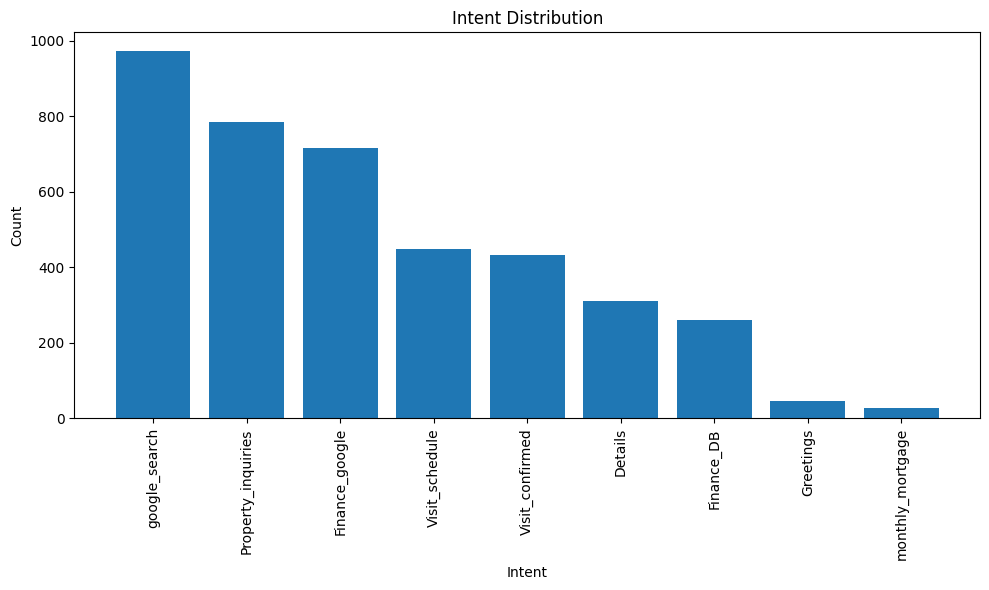

In [27]:
# Count the number of intents
intent_counts = preprocessed_data['Intents'].value_counts()

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(intent_counts.index, intent_counts.values)
plt.xlabel('Intent')
plt.ylabel('Count')
plt.title('Intent Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



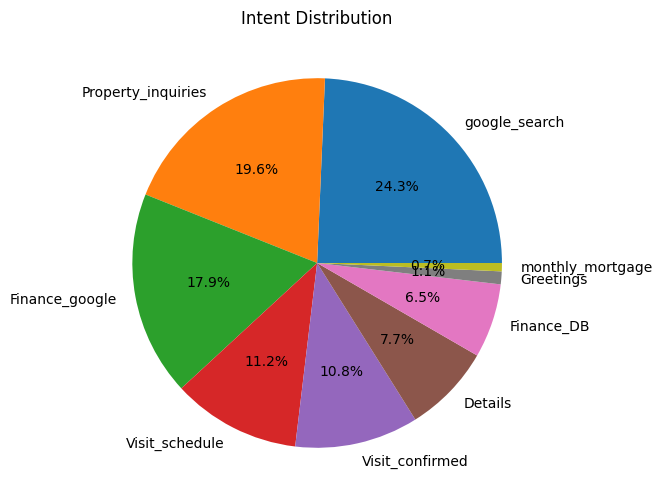

In [28]:
# Create a pie chart
plt.figure(figsize=(10,6))
plt.pie(intent_counts.values, labels=intent_counts.index, autopct='%1.1f%%')
plt.title('Intent Distribution')
plt.show()

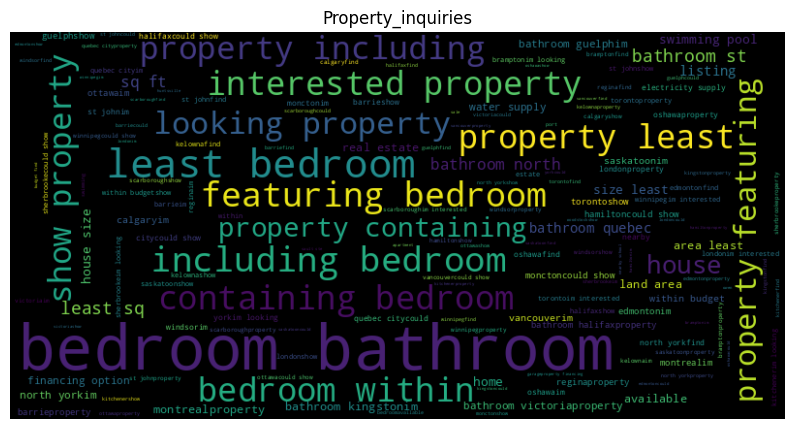

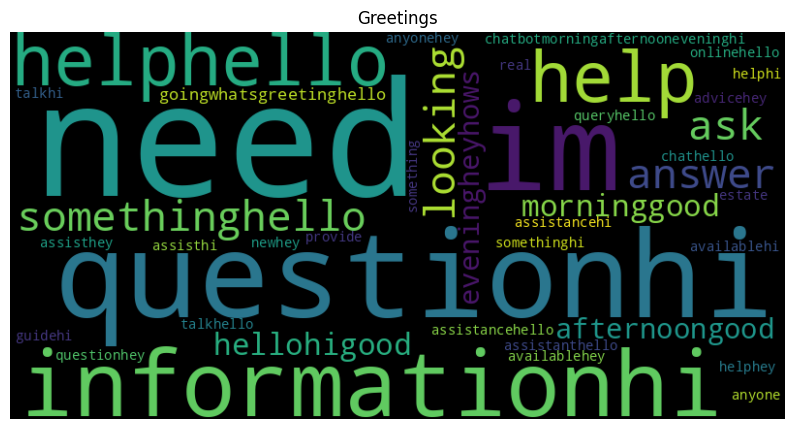

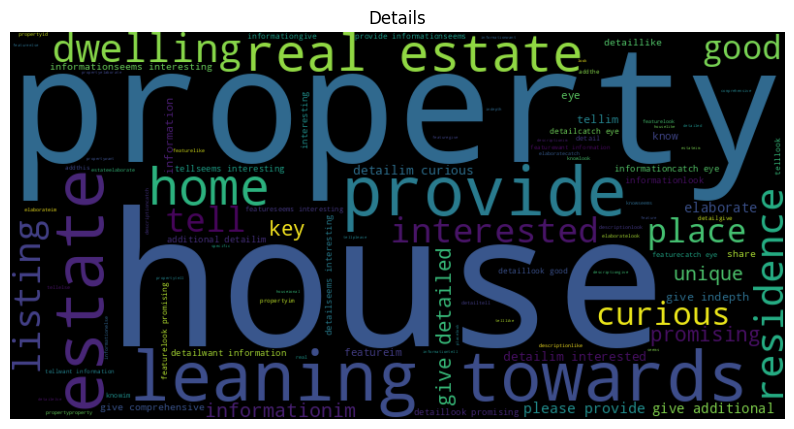

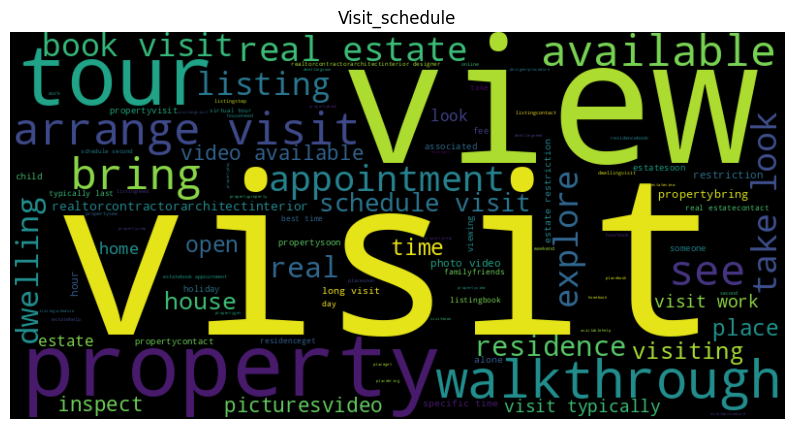

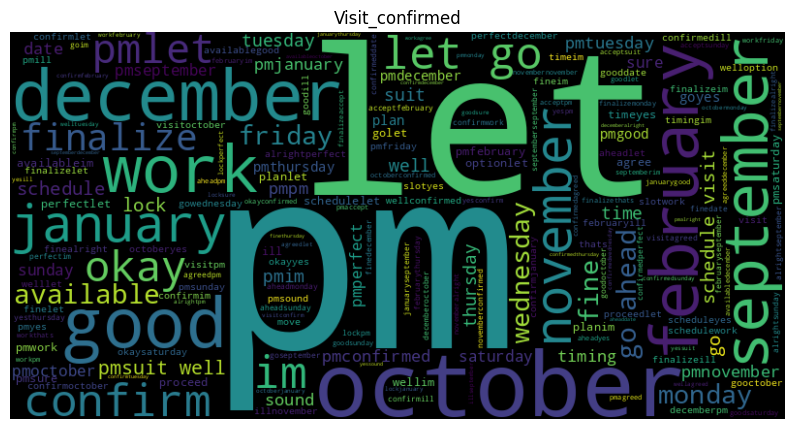

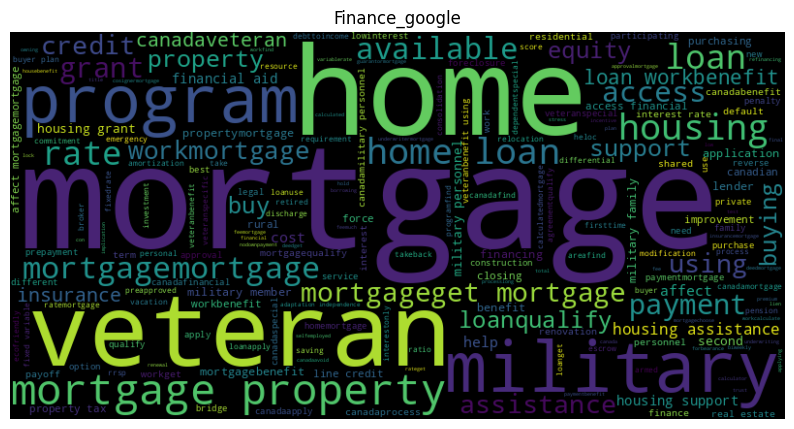

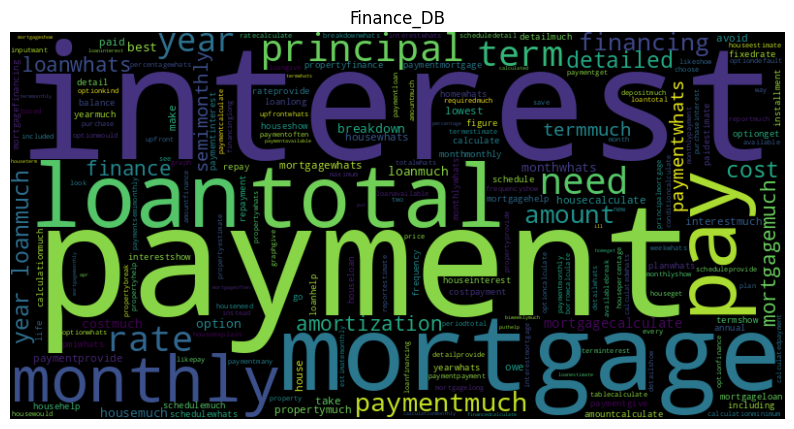

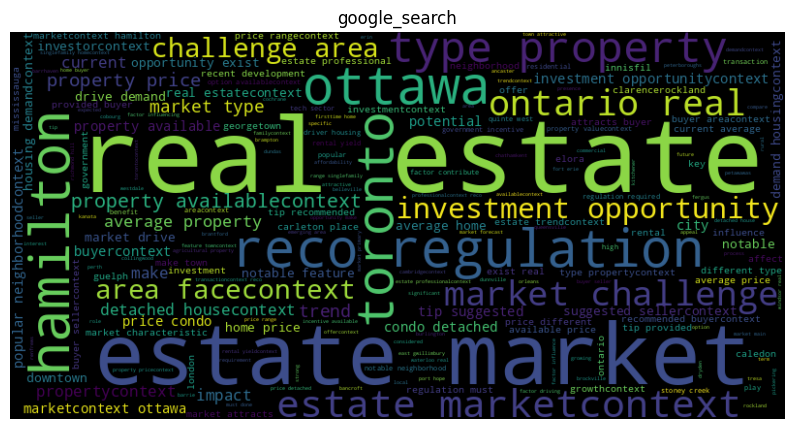

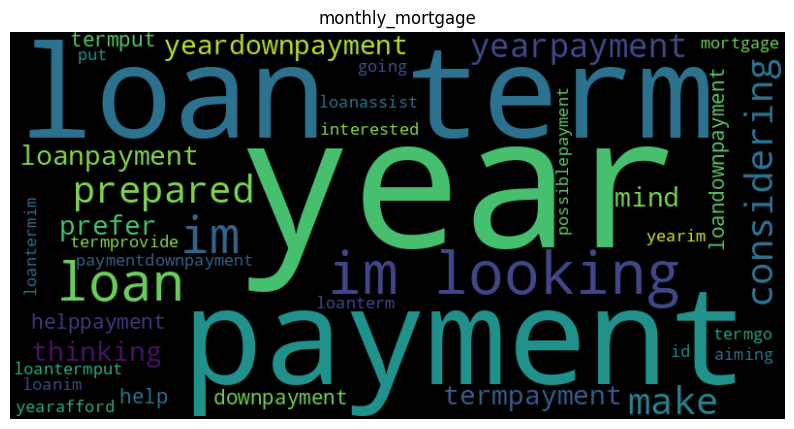

In [29]:
# Create a word cloud for each intent
for intent in preprocessed_data['Intents'].unique():
    intent_data = preprocessed_data[preprocessed_data['Intents'] == intent]
    words =''.join(intent_data['cleaned_questions'].tolist())
    wordcloud = WordCloud(width=800, height=400).generate(words)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(intent)
    plt.show()


In [30]:
# Topic Modeling
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LdaModel


# Split the data into text and intents
text_data = preprocessed_data['cleaned_questions']
intents = preprocessed_data['Intents']

# Preprocess the text data to split it into individual words or tokens
text_data = text_data.apply(lambda x: x.split())

# Create a dictionary for the text data
dictionary = corpora.Dictionary(text_data)

# Filter out words that appear in less than 2 documents or more than 0.5 of the total documents
dictionary.filter_extremes(no_below=2, no_above=0.5)

# Create a corpus for the text data
corpus = [dictionary.doc2bow(text) for text in text_data]

# Create a TF-IDF model
tfidf = TfidfModel(corpus)

# Perform topic modeling
lda_model = LdaModel(corpus=corpus, id2word=dictionary, passes=15, num_topics=7)

# Print the topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.077*"mortgage" + 0.047*"visit" + 0.045*"pm" + 0.041*"property"')
(1, '0.197*"loan" + 0.188*"term" + 0.146*"year" + 0.120*"$"')
(2, '0.088*"context" + 0.033*"home" + 0.026*"real" + 0.026*"estate"')
(3, '0.272*"payment" + 0.136*"$" + 0.118*"im" + 0.093*"make"')
(4, '0.116*"context" + 0.075*"market" + 0.072*"real" + 0.069*"estate"')
(5, '0.136*"property" + 0.132*"bedroom" + 0.109*"bathroom" + 0.056*"im"')
(6, '0.094*"estate" + 0.061*"real" + 0.043*"mortgage" + 0.039*"interest"')


In [31]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")



In [32]:
# Intent-Wise Keyword Extraction
from spacy import displacy

# Define a function to extract keywords from a text
def extract_keywords(text):
    doc = nlp(text)
    keywords = [token.text for token in doc if token.pos_ == 'NOUN' or token.pos_ == 'PROPN']
    return keywords

# Apply the function to each text in the preprocessed data
preprocessed_data['keywords'] = preprocessed_data['cleaned_questions'].apply(extract_keywords)

# Group the data by intent and extract the top keywords for each intent
intent_keywords = preprocessed_data.explode('keywords').groupby('Intents')['keywords'].apply(lambda x: x.value_counts().head(10))
# Print the top keywords for each intent
print(intent_keywords.to_string(max_rows=100))

Intents                        
Details             detail          91
                    information     79
                    property        60
                    estate          58
                    feature         46
                    house           46
                    eye             27
                    residence       27
                    home            24
                    place           21
Finance_DB          payment         77
                    mortgage        62
                    loan            58
                    interest        57
                    house           29
                    term            26
                    year            24
                    amount          15
                    rate            15
                    cost            13
Finance_google      mortgage       380
                    home           146
                    veteran        109
                    loan           106
                    canada      

In [33]:
# Encode intents
le = LabelEncoder()
preprocessed_data['intent_encoded'] = le.fit_transform(preprocessed_data['Intents'])

## Entity Extraction using Spacy

In [34]:
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define custom regex patterns for specific entities
patterns = {
    'bedroom': r'(\b(?:at least|more than|less than|up to|no less than|exactly)?\s*\d+\s*bedroom(?:s)?\b)',
    'bathroom': r'(\b(?:at least|more than|less than|up to|no less than|exactly)?\s*\d+\s*bathroom(?:s)?\b)',
    'house_type': r'\b(condo|house|apartment|townhouse)\b',
    'nearby': r'\b(hospital|school|grocery|public transport|recreational park)\b',
    'basement': r'\b(basement)\b',
    'house_size': r'\d+\s*(?:square\s*feet|sqft|square\s*meters|sqm)',
    'land_area': r'\d+\s*(?:square\s*feet|sqft|square\s*meters|sqm)',
    'water': r'\bwater\b',
    'electricity': r'\belectricity\b',
    'financing': r'\bfinancing\b',
    'status': r'\b(available|sold)\b',
    'swimming_pool': r'\bswimming pool\b',
    'property_taxes': r'\bproperty taxes\b',
    'renovation': r'\b(recent renovation|recent upgrades|renovated|upgraded)\b',
    'year_built': r'\b(built|constructed)\b',
    'move_in_ready': r'\b(move-in ready|move in ready)\b',
    'heating': r'\bheating\b',
    'cooling': r'\bcooling\b',
    'parking': r'\bparking\b',
    'repairs_needed': r'\brepairs needed\b',
    'basement': r'\bbasement\b',
    'visit_availability': r'\bvisit availability\b',
}

# Function to extract context
def extract_context(text, match):
    start, end = match.span()
    pre_context = text[max(0, start-50):start].strip()
    post_context = text[end:min(len(text), end+50)].strip()
    return f"{pre_context} {match.group(0)} {post_context}".strip()

# Function to extract entities using spaCy and custom regex
def extract_entities(text):
    doc = nlp(text)
    entities = {
        'bedroom': None,
        'bathroom': None,
        'property_price': None,
        'province': None,
        'city': None,
        'address': None,
        'house_type': None,
        'house_size': None,
        'land_area': None,
        'water': None,
        'electricity': None,
        'financing': None,
        'nearby': [],
        'status': None,
        'swimming_pool': None,
        'property_taxes': None,
        'renovation': None,
        'year_built': None,
        'move_in_ready': None,
        'heating': None,
        'cooling': None,
        'parking': None,
        'repairs_needed': None,
        'basement': None,
        'visit_availability': None,
        'detailed_summary': None,
        'option_number': None
    }

    # Extract entities using spaCy's NER
    for ent in doc.ents:
        if ent.label_ == "GPE":
            entities['city'] = ent.text
        elif ent.label_ == "MONEY":
            entities['property_price'] = ent.text
        elif ent.label_ == "DATE" and re.search(r'\d{4}', ent.text):
            entities['year_built'] = ent.text

    # Extract entities using custom regex patterns
    for entity, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            context = extract_context(text, match)
            if entity == 'nearby':
                entities[entity].append(match.group(0))
            else:
                entities[entity] = match.group(0)
    # Extract option number for details using custom regex patterns
    option_match = re.search(r'option\s*(\d+)', text, re.IGNORECASE)
    if option_match:
        entities['option_number'] = int(option_match.group(1))

    return entities

# Test query
test_query = ("I'm interested in option 2. Can I have more information?")

entities = extract_entities(test_query)
print(entities)


{'bedroom': None, 'bathroom': None, 'property_price': None, 'province': None, 'city': None, 'address': None, 'house_type': None, 'house_size': None, 'land_area': None, 'water': None, 'electricity': None, 'financing': None, 'nearby': [], 'status': None, 'swimming_pool': None, 'property_taxes': None, 'renovation': None, 'year_built': None, 'move_in_ready': None, 'heating': None, 'cooling': None, 'parking': None, 'repairs_needed': None, 'basement': None, 'visit_availability': None, 'detailed_summary': None, 'option_number': 2}


In [35]:
# Training model to classify intents based on questions using LSTM

questions = preprocessed_data['cleaned_questions']
intents = preprocessed_data['Intents']
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
sequences = tokenizer.texts_to_sequences(questions)
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [36]:
max_sequence_length,padded_sequences

(19,
 array([[ 19,   1,  17, ...,   0,   0,   0],
        [  9,  27,   1, ...,   0,   0,   0],
        [  9,  21,   1, ...,   0,   0,   0],
        ...,
        [  9, 589, 413, ...,   0,   0,   0],
        [ 77,  24, 240, ...,   0,   0,   0],
        [ 24, 478, 101, ...,   0,   0,   0]], dtype=int32))

In [37]:
preprocessed_data['intent_encoded'].unique()

array([4, 3, 0, 6, 5, 2, 1, 7, 8])

In [38]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, preprocessed_data['intent_encoded'], test_size=0.2, random_state=42,stratify=preprocessed_data['intent_encoded'])


In [39]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3203, 19), (801, 19), (3203,), (801,))

In [40]:
y_train.value_counts()

intent_encoded
7    779
4    629
2    574
6    360
5    346
0    248
1    208
3     36
8     23
Name: count, dtype: int64

In [41]:
y_test.value_counts()

intent_encoded
7    195
4    157
2    143
6     90
5     87
0     62
1     52
3      9
8      6
Name: count, dtype: int64

# Using Word2Vec, LSTM to train model

In [42]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred))


Naive Bayes Accuracy: 0.3283395755305868
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.32      0.31        62
           1       0.13      0.35      0.19        52
           2       0.17      0.04      0.07       143
           3       0.03      0.56      0.05         9
           4       0.55      0.63      0.59       157
           5       0.38      0.28      0.32        87
           6       0.04      0.01      0.02        90
           7       0.86      0.46      0.60       195
           8       0.08      0.17      0.11         6

    accuracy                           0.33       801
   macro avg       0.28      0.31      0.25       801
weighted avg       0.43      0.33      0.35       801



In [43]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.4369538077403246
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.00      0.00      0.00        52
           2       0.25      0.64      0.36       143
           3       0.00      0.00      0.00         9
           4       0.92      0.37      0.53       157
           5       0.25      0.24      0.25        87
           6       0.25      0.01      0.02        90
           7       0.61      0.92      0.73       195
           8       0.00      0.00      0.00         6

    accuracy                           0.44       801
   macro avg       0.25      0.24      0.21       801
weighted avg       0.43      0.44      0.38       801



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [44]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9151061173533084
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84        62
           1       0.79      0.73      0.76        52
           2       0.83      0.94      0.88       143
           3       0.80      0.44      0.57         9
           4       0.99      1.00      1.00       157
           5       0.91      0.89      0.90        87
           6       0.86      0.97      0.91        90
           7       0.99      0.95      0.97       195
           8       0.67      0.33      0.44         6

    accuracy                           0.92       801
   macro avg       0.86      0.78      0.81       801
weighted avg       0.92      0.92      0.91       801



In [45]:
# Model architecture
'''model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, 64, input_length=max_sequence_length),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(np.unique(preprocessed_data['intent_encoded'])), activation='softmax')  # Adjust output units based on unique intents
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) '''


"model = tf.keras.Sequential([\n    tf.keras.layers.Embedding(len(word_index) + 1, 64, input_length=max_sequence_length),\n    tf.keras.layers.LSTM(128),\n    tf.keras.layers.Dense(len(np.unique(preprocessed_data['intent_encoded'])), activation='softmax')  # Adjust output units based on unique intents\n])\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer='adam',\n              metrics=['accuracy']) "

In [46]:
# Enhanced model architecture
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=64, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=False)),  # Bidirectional LSTM
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularized Dense layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(len(np.unique(preprocessed_data['intent_encoded'])), activation='softmax')  # Output layer
])
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Set up callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
# Training the model with callbacks
model.fit(X_train, y_train,
          epochs=20,  # Increase epochs for more thorough training
          batch_size=32,
          validation_split=0.2)
          #callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.2679 - loss: 3.1861 - val_accuracy: 0.5944 - val_loss: 1.5257
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.6445 - loss: 1.3759 - val_accuracy: 0.8034 - val_loss: 0.7478
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8258 - loss: 0.7362 - val_accuracy: 0.9314 - val_loss: 0.4203
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9241 - loss: 0.4093 - val_accuracy: 0.9501 - val_loss: 0.2830
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9492 - loss: 0.3093 - val_accuracy: 0.9563 - val_loss: 0.2545
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9686 - loss: 0.2216 - val_accuracy: 0.9657 - val_loss: 0.2135
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9684 - loss: 0.2106 - val_accuracy: 0.9688 - val_loss: 0.1890
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9723 - loss: 0.1739 - val_accuracy: 0.9

In [48]:
# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Test Accuracy")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Accuracy
                    precision    recall  f1-score   support

           Details       1.00      0.98      0.99        62
        Finance_DB       0.90      0.87      0.88        52
    Finance_google       0.93      0.97      0.95       143
         Greetings       0.86      0.67      0.75         9
Property_inquiries       0.99      1.00      1.00       157
   Visit_confirmed       0.99      0.99      0.99        87
    Visit_schedule       0.99      0.99      0.99        90
     google_search       0.98      0.98      0.98       195
  monthly_mortgage       1.00      0.83      0.91         6

          accuracy                           0.97       801
         macro avg       0.96      0.92      0.94       801
      weighted avg       0.97      0.97      0.97       801



In [49]:
# Evaluation
y_pred_train = model.predict(X_train)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
print("Train Accuracy")
print(classification_report(y_train, y_pred_train_classes, target_names=le.classes_))

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Train Accuracy
                    precision    recall  f1-score   support

           Details       1.00      1.00      1.00       248
        Finance_DB       0.95      0.91      0.93       208
    Finance_google       0.96      0.99      0.98       574
         Greetings       1.00      0.94      0.97        36
Property_inquiries       1.00      1.00      1.00       629
   Visit_confirmed       1.00      1.00      1.00       346
    Visit_schedule       1.00      1.00      1.00       360
     google_search       1.00      0.99      1.00       779
  monthly_mortgage       1.00      0.83      0.90        23

          accuracy                           0.99      3203
         macro avg       0.99      0.96      0.98      3203
      weighted avg       0.99      0.99      0.99      3203



<Axes: >

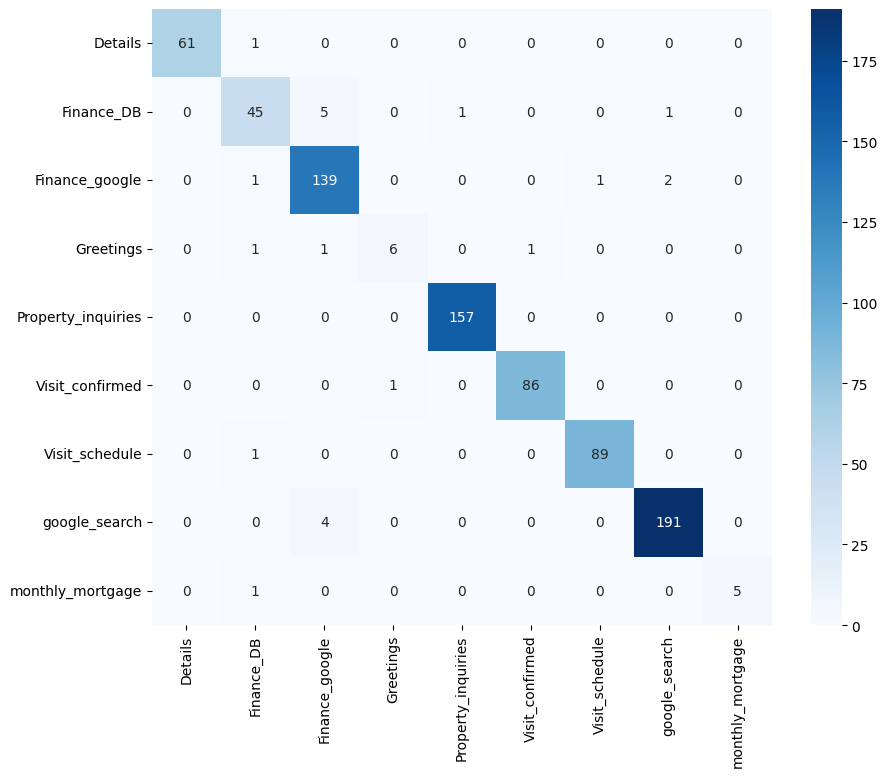

In [50]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)

In [51]:
import os
import joblib

# Define the directory where you want to save the model
model_dir = 'model'

# Check if the directory exists, if not, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Assuming `model` is your trained model
joblib.dump(model, os.path.join(model_dir, 'new_lstm_model.pkl'))

print("Model saved successfully!")


Model saved successfully!


In [52]:
# Save tokenizer
joblib.dump(tokenizer, 'model/lsmt_tokenizer.pkl')

# Save label encoder
joblib.dump(le, 'model/lstm_label_encoder.pkl')

['model/lstm_label_encoder.pkl']

In [53]:
print(tf.__version__)

2.17.0


In [54]:
# Example prediction
#new_question = "Hi"
def classify_intent(test_query):

  new_sequence = tokenizer.texts_to_sequences([test_query])
  new_padded_sequence = pad_sequences(new_sequence, maxlen=max_sequence_length, padding='post')

  prediction = model.predict(new_padded_sequence)
  predicted_intent = np.argmax(prediction)
  # Convert predicted intent (scalar) to a 1-dimensional array
  predicted_intent_array = np.array([predicted_intent])

  # Decode the encoded intent back to its original label
  predicted_intent_label = le.inverse_transform(predicted_intent_array)[0]
  return predicted_intent_label

#print(f"Predicted Intent:{predicted_intent_array} , {predicted_intent_label}")

In [55]:
# Using Word to Vec

# Composing Answers by querying results from vector datasets

In [56]:
# Querying From datasets
property_dataset = [
    {
        "id": 1,
        "bedrooms": 3,
        "bathrooms": 2,
        "price": 350000,
        "city": "Toronto",
        "address": "11 Crescent Place",
        "nearby": ["TTC", "hospital"],
        "financing_options": "Available",
        "house_type": "house",
        "year_built": 2015,
        "swimming_pool": True,
        "parking": True,
        "basement": True,
        "status": "available"
    },
    # Add more properties here
]

In [57]:
import pandas as pd

# Create a DataFrame
data = {
    "Bedroom": [2, 3, 4,5,3,2, 3, 4, 2, 3],
    "Bathroom": [1, 2, 3, 1, 2, 3, 1, 2, 3, 1],
    "Price": [500000, 600000, 700000, 800000, 500000, 600000, 700000, 800000, 600000, 700000],
    "City": ["Toronto", "Toronto", "Toronto", "Kitchener","Toronto", "Kitchener", "Kitchener", "Toronto", "Kitchener","Kitchener"],
    "House Type": ["Condo", "House", "Apartment", "Townhouse", "Condo", "House", "Apartment", "Townhouse", "House", "Condo"],
    "House Size": ["150 sqft", "250 sqft", "350 sqft", "450 sqft", "150 sqft", "250 sqft", "350 sqft", "450 sqft", "250 sqft", "350 sqft"],
    "Water": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Electricity": ["Yes", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "Yes", "No"],
    "Financing": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Nearby": ["Hospital, School", "School, Grocery", "Grocery, Public Transport", "Public Transport, Recreational Park", "Hospital, School", "School, Grocery", "Grocery, Public Transport", "Public Transport, Recreational Park", "Hospital, School", "School, Grocery"],
    "Status": ["Available", "Sold", "Available", "Sold", "Available", "Sold", "Available", "Sold", "Available", "Sold"],
    "Swimming Pool": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Recent renovation/upgrades": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Year built": [2010, 2012, 2014, 2016, 2010, 2012, 2014, 2016, 2012, 2014],
    "Move-in-ready": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Heating": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Cooling": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Parking": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Repairs needed?": ["No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes"],
    "Basement": ["Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes", "No"],
    "Visit availability date time": ["2024/12/10", "2024/12/11", "2024/12/12", "2024/12/13", "2024/12/10", "2024/12/11", "2024/12/12", "2024/12/13", "2024/12/11", "2024/12/12"],
    "Detailed/ summary of property": ["Spacious condo in downtown Toronto", "Beautiful house with a large backyard", "Modern apartment with city views", "Townhouse in a quiet neighborhood", "Cozy condo in Kitchener", "Large house with a garden", "Apartment near public transport", "Townhouse close to amenities", "House with modern finishes", "Condo with upgraded features"]
}

property_dataset = pd.DataFrame(data)




In [58]:
property_dataset.head()

,Bedroom,Bathroom,Price,City,House Type,House Size,Water,Electricity,Financing,Nearby,...,Recent renovation/upgrades,Year built,Move-in-ready,Heating,Cooling,Parking,Repairs needed?,Basement,Visit availability date time,Detailed/ summary of property
0,2,1,500000,Toronto,Condo,150 sqft,Yes,Yes,Yes,"Hospital, School",...,Yes,2010,Yes,Yes,Yes,Yes,No,Yes,2024/12/10,Spacious condo in downtown Toronto
1,3,2,600000,Toronto,House,250 sqft,No,Yes,No,"School, Grocery",...,No,2012,No,No,No,No,Yes,No,2024/12/11,Beautiful house with a large backyard
2,4,3,700000,Toronto,Apartment,350 sqft,Yes,No,Yes,"Grocery, Public Transport",...,Yes,2014,Yes,Yes,Yes,Yes,No,Yes,2024/12/12,Modern apartment with city views
3,5,1,800000,Kitchener,Townhouse,450 sqft,No,Yes,No,"Public Transport, Recreational Park",...,No,2016,No,No,No,No,Yes,No,2024/12/13,Townhouse in a quiet neighborhood
4,3,2,500000,Toronto,Condo,150 sqft,Yes,No,Yes,"Hospital, School",...,Yes,2010,Yes,Yes,Yes,Yes,No,Yes,2024/12/10,Cozy condo in Kitchener


In [59]:

         '''if more than 1 houses found =  "These are the available houses for your requirements.  {}" chose 1 or be more specific
         if more specific: query again and display results "These are the available houses for your requirements.  {}" chose 1 or be more specific
          if chosed : detail description of that house, you want to visit the house you want ask more questions related to financing, ammenities
            if visit: confirm date for appointment
         if financing options: detail about finance options based on requirements, randomly create few options
         if porprty taxes: detail about property taxes based on requirements, randomly create few options
         if buying process: detail about buying process based on requirements, randomly create few or 1 options
         if market trends: detail about market trends based on requirements, randomly create few or 1 options
         if statistical analysis: detail about statistical analysis such as minimum, average, and maximum prices of house for requirements given
         try to create as much as different intents like this as possible'''

'if more than 1 houses found =  "These are the available houses for your requirements.  {}" chose 1 or be more specific\nif more specific: query again and display results "These are the available houses for your requirements.  {}" chose 1 or be more specific\n if chosed : detail description of that house, you want to visit the house you want ask more questions related to financing, ammenities\n   if visit: confirm date for appointment\nif financing options: detail about finance options based on requirements, randomly create few options\nif porprty taxes: detail about property taxes based on requirements, randomly create few options\nif buying process: detail about buying process based on requirements, randomly create few or 1 options\nif market trends: detail about market trends based on requirements, randomly create few or 1 options\nif statistical analysis: detail about statistical analysis such as minimum, average, and maximum prices of house for requirements given\ntry to create as

In [60]:
from typing import Optional, Dict, List

def extract_number(value: Optional[str]) -> Optional[int]:
    if isinstance(value, str):
        numbers = re.findall(r'\d+', value)
        return int(numbers[0]) if numbers else None
    elif isinstance(value, (int, float)):
        return int(value)
    return None

def filter_by_city(properties: pd.DataFrame, city: Optional[str]) -> pd.DataFrame:
    if not city:
        return properties
    return properties[properties['City'].str.lower() == city.lower()]

def filter_properties(entities: Dict, property_df: pd.DataFrame) -> pd.DataFrame:
    filtered = property_df

    # Apply city filter (handled by spaCy)
    filtered = filter_by_city(filtered, entities.get('city'))

    # Bedroom filter
    if entities.get('bedroom'):
        bedrooms = extract_number(entities['bedroom'])
        if bedrooms:
            filtered = filtered[filtered['Bedroom'] >= bedrooms]

    # Bathroom filter
    if entities.get('bathroom'):
        bathrooms = extract_number(entities['bathroom'])
        if bathrooms:
            filtered = filtered[filtered['Bathroom'] >= bathrooms]

    # Property price filter
    if entities.get('property_price'):
        max_price = extract_number(entities['property_price'])
        if max_price:
            filtered = filtered[filtered['Price'] <= max_price]

    # House type filter
    if entities.get('house_type'):
        filtered = filtered[filtered['House Type'].str.lower() == entities['house_type'].lower()]

    # Swimming pool filter
    if entities.get('swimming_pool'):
        filtered = filtered[filtered['Swimming Pool'] == (entities['swimming_pool'].lower() == 'yes')]

    # Parking filter
    if entities.get('parking'):
        filtered = filtered[filtered['Parking'] == (entities['parking'].lower() == 'yes')]

    # Year built filter
    if entities.get('year_built'):
        year = extract_number(entities['year_built'])
        if year:
            filtered = filtered[filtered['Year built'] >= year]

    # Basement filter
    if entities.get('basement'):
        filtered = filtered[filtered['Basement'] == (entities['basement'].lower() == 'yes')]

    # House size filter
    if entities.get('house_size'):
        size = extract_number(entities['house_size'])
        if size:
            filtered = filtered[filtered['House Size'].apply(extract_number) >= size]
    # Nearby amenities filter
    if entities.get('nearby'):
        filtered = filtered[filtered['Nearby'].apply(lambda x: any(amenity.lower() in [a.lower() for a in x] for amenity in entities['nearby']))]

    # Status filter
    if entities.get('status'):
        filtered = filtered[filtered['Status'].str.lower() == entities['status'].lower()]

    # Return the filtered properties with specified columns
    if filtered.empty:
        return ["No properties found"]
    #return filtered
    result = []
    for _, row in filtered.iterrows():
        result.append(row.to_dict())

    return result


In [61]:
from typing import Dict, List, Union, Callable

class RealEstateChatbot:
    def __init__(self, filter_properties_func: Callable[[Dict, pd.DataFrame], List[Dict]]):
        self.matching_properties = []
        self.filter_properties = filter_properties_func
        self.selected_option_number = None

    def compose_answer(self, intent: str, entities: Dict, property_df: pd.DataFrame) -> str:
        if intent == "Greetings":
            return "Hello! Welcome to our real estate chatbot. How can I assist you with your property search today?"

        elif intent == "Property_inquiries":
            self.matching_properties = self.filter_properties(entities, property_df)

            if not self.matching_properties:
                return "No properties found matching your criteria."

            # Sort properties by price (optional)
            self.matching_properties = sorted(self.matching_properties, key=lambda x: x['Price'])

            # Select top 3 properties
            top_properties = self.matching_properties[:3]

            # Format the answer
            response_lines = [
                "These are the top property listings for your requirements. Select one to know the details by writing the option number or type 'exit':"
            ]
            for idx, prop in enumerate(top_properties):
                response_lines.append(
                    f"{idx + 1}. Price: ${prop['Price']}, City: {prop['City']}, "
                    f"Bedrooms: {prop['Bedroom']}, Bathrooms: {prop['Bathroom']}, "
                    f"House Type: {prop['House Type']}, House Size: {prop['House Size']}"
                )

            return "\n".join(response_lines)

        elif intent == "Details":
            option_number = entities.get('option_number')
            if option_number is not None and 1 <= option_number <= len(self.matching_properties):
                self.selected_option_number = option_number
                property_details = self.matching_properties[option_number - 1]
                details = "This is the detailed description for the property you chose:\n"
                for key, value in property_details.items():
                    details += f"{key}: {value}\n"
                return details
            else:
                return "Invalid option number. Please select a valid option."

        elif intent == "Visit_schedule":
           if self.selected_option_number is not None and 1 <= self.selected_option_number <= len(self.matching_properties):
                property_details = self.matching_properties[self.selected_option_number - 1]
                visit_availability = property_details.get('Visit availability date time', 'No visit dates available')
                return (
                    "These are the available dates to view the property. "
                    "If you want to schedule the appointment for a visit, choose one date from below:\n"
                    f"{visit_availability}"
                )
        else:
                return "Please select a property first by inquiring about property details."




In [62]:
'''test_query = ("Can you show me houses with at least 3 bedrooms and 2 bathrooms in Toronto?")
entities = extract_entities(test_query)
intent = classify_inteb vnt(test_query)
print(intent,entities)'''




'test_query = ("Can you show me houses with at least 3 bedrooms and 2 bathrooms in Toronto?")\nentities = extract_entities(test_query)\nintent = classify_inteb vnt(test_query)\nprint(intent,entities)'

In [63]:
#chatbot = RealEstateChatbot()
chatbot = RealEstateChatbot(filter_properties_func=filter_properties)
#response = chatbot.compose_answer(intent, entities, property_df)
#response = chatbot.compose_answer(intent, entities, property_dataset)

In [64]:
def chat():
    matching_properties = []
    while True:
        user_input = input("User: ")
        if user_input.lower() == "exit":
            break
        entities = extract_entities(user_input)
        intent = classify_intent(user_input)
        answer = chatbot.compose_answer(intent, entities, property_dataset)
        print("Bot:", answer)